In [8]:
import pandas as pd

In [27]:
df = pd.read_csv('prep_karl_marx_str.csv')

In [28]:
df

,timestamp,value
0,2023-01-01 00:00:00,33.470417
1,2023-01-01 01:00:00,18.732500
2,2023-01-01 02:00:00,21.103913
3,2023-01-01 03:00:00,20.291667
4,2023-01-01 04:00:00,17.769167
...,...,...
8779,2024-01-01 19:00:00,13.168261
8780,2024-01-01 20:00:00,11.634167
8781,2024-01-01 21:00:00,10.825417
8782,2024-01-01 22:00:00,10.683200


In [29]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

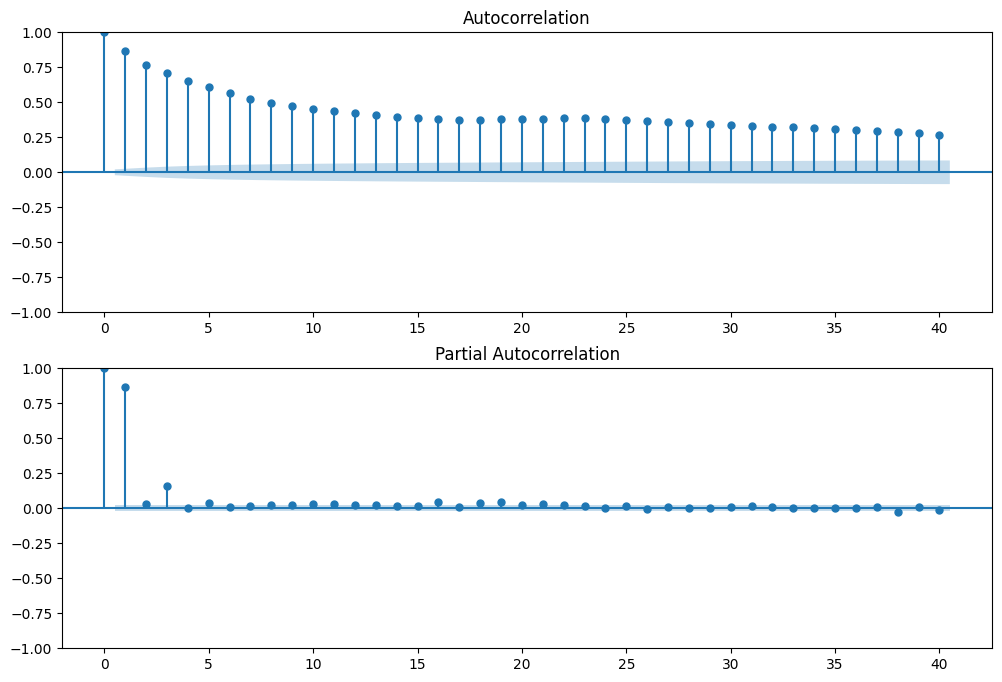

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot Autocorrelation and Partial Autocorrelation Functions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['value'], lags=40, ax=ax1)  # ACF plot
plot_pacf(df['value'], lags=40, ax=ax2)  # PACF plot

plt.show()


In [15]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test to check stationarity
adf_result = adfuller(df['value'])

# Create a readable output of the test results
adf_output = {
    'Test Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Lags Used': adf_result[2],
    'Number of Observations Used': adf_result[3],
    'Critical Values': adf_result[4],
    'Maximized Information Criterion': adf_result[5]
}

adf_output


{'Test Statistic': -9.631115167515905,
 'p-value': 1.6112718018563705e-16,
 'Lags Used': 21,
 'Number of Observations Used': 8762,
 'Critical Values': {'1%': -3.4310965438036183,
  '5%': -2.8618699228195106,
  '10%': -2.5669456129409847},
 'Maximized Information Criterion': 69649.09236898914}

Nullhypothese verwerfen, die Zetreihe ist also stationär.

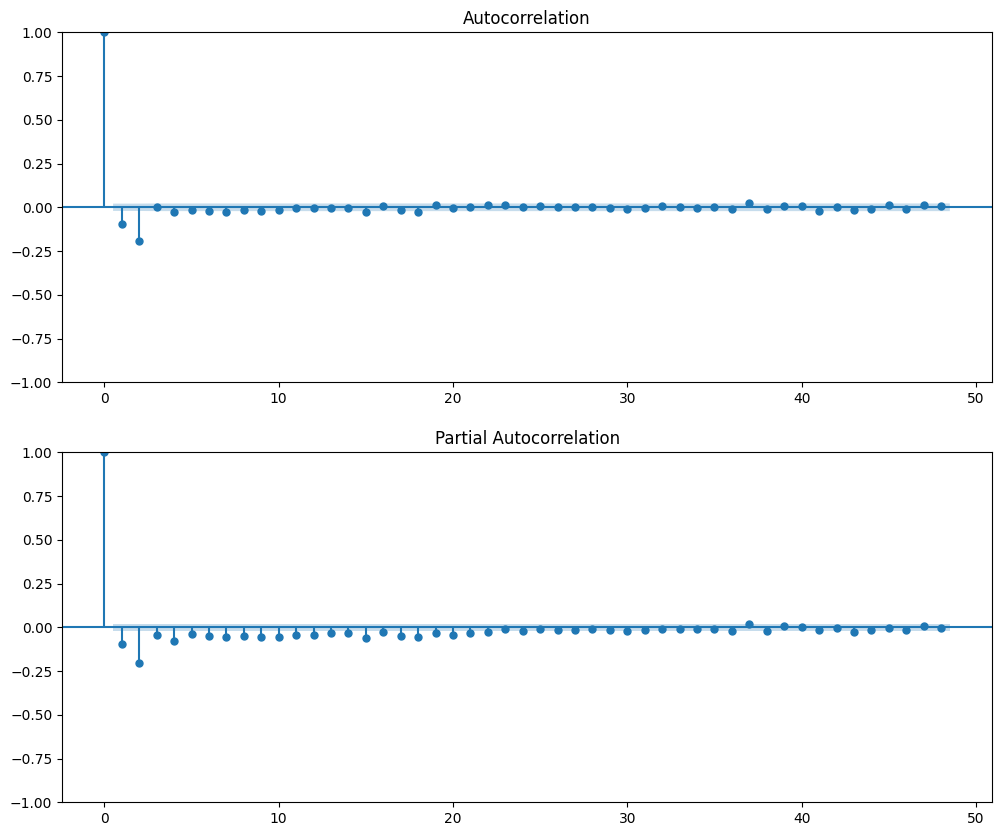

In [16]:
# Differencing the data
df_differenced = df['value'].diff().dropna()

# Plot Autocorrelation and Partial Autocorrelation Functions for differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_differenced, lags=48, ax=ax1)  # ACF plot for differenced data
plot_pacf(df_differenced, lags=48, ax=ax2)  # PACF plot for differenced data

plt.show()


In [17]:
# Perform Augmented Dickey-Fuller test on the differenced data to check for stationarity
adf_result_differenced = adfuller(df_differenced)

# Create a readable output of the test results for the differenced data
adf_output_differenced = {
    'Test Statistic': adf_result_differenced[0],
    'p-value': adf_result_differenced[1],
    'Lags Used': adf_result_differenced[2],
    'Number of Observations Used': adf_result_differenced[3],
    'Critical Values': adf_result_differenced[4],
    'Maximized Information Criterion': adf_result_differenced[5]
}

adf_output_differenced


{'Test Statistic': -20.657875430549502,
 'p-value': 0.0,
 'Lags Used': 37,
 'Number of Observations Used': 8745,
 'Critical Values': {'1%': -3.4310979954871965,
  '5%': -2.861870564286558,
  '10%': -2.566945954398184},
 'Maximized Information Criterion': 69719.85467603362}

In [20]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

p = q = range(0, 3)
d = 1

df.index.freq = 'h'

model_results_original = []

# Iterate over all combinations of p, d, and q to fit ARIMA model and compute AIC for original data
for p_value in p:
    for q_value in q:
        try:
            # Fit ARIMA model
            model = ARIMA(df['value'], order=(p_value, d, q_value))
            model_fit = model.fit()
            # Store results
            model_results_original.append((p_value, d, q_value, model_fit.aic))
        except Exception as e:
            print(f"Failed to fit ARIMA({p_value},{d},{q_value}): {e}")

# Convert results to a DataFrame for better visualization
model_results_original_df = pd.DataFrame(model_results_original, columns=['p', 'd', 'q', 'AIC'])

# Find the model with the lowest AIC
best_model_original = model_results_original_df.loc[model_results_original_df['AIC'].idxmin()]

model_results_original_df, best_model_original


(   p  d  q           AIC
 0  0  1  0  70810.542273
 1  0  1  1  70671.878510
 2  0  1  2  70251.241500
 3  1  1  0  70729.185939
 4  1  1  1  70077.070353
 5  1  1  2  70073.943618
 6  2  1  0  70352.994338
 7  2  1  1  70075.721278
 8  2  1  2  70015.769411,
 p          2.000000
 d          1.000000
 q          2.000000
 AIC    70015.769411
 Name: 8, dtype: float64)

In [21]:
import pickle

# Fit the best ARIMA model
best_arima_model = ARIMA(df['value'], order=(2, 1, 2))
best_arima_model_fit = best_arima_model.fit()

# Save the model to a file
model_filename = 'karl_marx_arima_212_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_arima_model_fit, file)

model_filename


'karl_marx_arima_212_model.pkl'

In [26]:
import pickle

# Pfad zur gespeicherten Modell-Datei
model_filename = 'karl_marx_arima_212_model.pkl'

# Laden des Modells
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Anzahl der Zeitschritte, die vorhergesagt werden sollen
num_forecast_steps = 24

# Vorhersage machen
forecast = loaded_model.forecast(steps=num_forecast_steps)

print("Die Vorhersage für die nächsten", num_forecast_steps, "Zeitpunkte ist:", forecast)


Die Vorhersage für die nächsten 100 Zeitpunkte ist: 2024-01-02 00:00:00    16.614045
2024-01-02 01:00:00    22.131586
2024-01-02 02:00:00    25.758893
2024-01-02 03:00:00    28.703373
2024-01-02 04:00:00    30.690594
                         ...    
2024-01-05 23:00:00    36.477652
2024-01-06 00:00:00    36.477652
2024-01-06 01:00:00    36.477652
2024-01-06 02:00:00    36.477652
2024-01-06 03:00:00    36.477652
Freq: h, Name: predicted_mean, Length: 100, dtype: float64
